# Test quality of initial field distribution

- check Meep's integration routine
- check implementation of Laguerre-Gauss beam fields
- check transition from cartesian to spherical coordinates

In [5]:
import numpy as np
import scipy as sp

from scipy.integrate import dblquad

def complex_dblquad(func, a, b, gfun, hfun, **kwargs):
    """Integrates the real and imaginary part of the given function."""
    def real_func(x, y):
        return sp.real(func(x, y))
    def imag_func(x, y):
        return sp.imag(func(x, y))
    
    def real_integral():
        return dblquad(real_func, a, b, gfun, hfun, **kwargs)
    def imag_integral():
        return dblquad(imag_func, a, b, gfun, hfun, **kwargs)
    
    return (real_integral()[0] + 1j * imag_integral()[0], real_integral()[1:], imag_integral()[1:])


def f_Gauss_cartesian(W_y, k_y, k_z): 
    """
    """
    return sp.exp(-(W_y ** 2) * (k_y ** 2 + k_z ** 2) / 4)

def f_Gauss_spherical(W_y, theta):
    """
    """
    return sp.exp(-((k1 * W_y) * theta / 2) ** 2)

def f_Laguerre_Gauss_cartesian(W_y, m, k_y, k_z):
    """
    """
    k_x = sp.sqrt(k1**2 - k_y**2 - k_z**2)
    
    phi   = np.arctan2(k_y / k1, -k_z / k1)
    theta = np.arccos(k_x / k1)
    
    return f_Gauss_cartesian(W_y, k_y, k_z) * (theta ** np.abs(m)) * sp.exp(1j * m * phi)

def f_Laguerre_Gauss_spherical(W_y, m, theta, phi):
    """
    """
    return f_Gauss_spherical(W_y, theta) * (theta ** np.abs(m)) * sp.exp(1j * m * phi)

def integrand_cartesian(x, y, z, k_y, k_z):
    """
    """
    ## first variant (taking the real part of the suqare root)
    #return f_Gauss_cartesian(w_0, k_y, k_z) * sp.exp(1.0j * (x * (sp.sqrt(k**2 - k_y**2 - k_z**2).real) + 
    #                                                         y * k_y + 
    #                                                         z * k_z))
    
    ## second variant (leave square root as is, but perform second integration with non-constant bounds)
    ## Gauss
    #k_x = sp.sqrt(k1**2 - k_y**2 - k_z**2)
    #return f_Gauss_cartesian(w_0, k_y, k_z) * sp.exp(1.0j * (x * k_x + y * k_y + z * k_z))
    
    ## Laguerre-Gauss
    k_x = sp.sqrt(k1**2 - k_y**2 - k_z**2)
    return f_Laguerre_Gauss_cartesian(w_0, m_charge, k_y, k_z) * sp.exp(1j * (x * k_x + y * k_y + z * k_z))

def integrand_spherical(x, y, z, theta, phi):
    """
    """
    return (k1 ** 2) * np.sin(theta) * np.cos(theta) * f_Laguerre_Gauss_spherical(w_0, m_charge, theta, phi) * \
           sp.exp(1j * k1 * (np.sin(theta) * (y * np.sin(phi) - z * np.cos(phi)) + np.cos(theta) * x))

def psi_cartesian(x, y, z):
    """
    """
    integrand_ = lambda k_y, k_z: integrand_cartesian(x, y, z, k_y, k_z)
    
    ## constant integration bounds (appropriate for first variant)
    #return complex_dblquad(integrand_, -k1, k1, lambda x: -k1, lambda x: k1)[0]
    
    ## non-constant integration bounds (appropriate for second variant)
    return complex_dblquad(integrand_, -k1, k1, lambda x: -np.sqrt(k1**2 - x**2), lambda x: np.sqrt(k1**2 - x**2))[0]
    
def psi_spherical(x, y, z):
    """
    """
    integrand_ =  lambda phi, theta: integrand_spherical(x, y, z, theta, phi)
    
    return complex_dblquad(integrand_, 0.0, np.pi/2, lambda x: 0.0, lambda x: 2*np.pi)[0]
    
vec_psi_cartesian = np.vectorize(psi_cartesian)
vec_psi_spherical = np.vectorize(psi_spherical)

In [2]:
%time
## test paramters (free space propagation, i.e. n1=n2=n_ref=1)
kw_0     = 8
m_charge = 2
n1       = 1

## meep specific
freq    = 4
x_shift = -2.15

## derived values
k_vac = 2 * np.pi * freq
k1    = n1 * k_vac
w_0   = kw_0 / k_vac

print("Gauss spectrum (cartesian): ", f_Gauss_cartesian(w_0, 1.0, 5.2))
print("Gauss spectrum (spherical): ", f_Gauss_spherical(w_0, np.pi/3))
print("\n")
print("L-G spectrum   (cartesian): ", f_Laguerre_Gauss_cartesian(w_0, m_charge, 1.0, 5.2))
print("L-G spectrum   (spherical): ", f_Laguerre_Gauss_spherical(w_0, m_charge, np.pi/3, np.pi/4))
print("\n")
print("integrand      (cartesian): ", integrand_cartesian(x_shift, 0.3, 0.5, 4.0, 0.0))
print("integrand      (spherical): ", integrand_spherical(x_shift, 0.3, 0.5, np.pi/3, np.pi/4))
print("\n")
print("psi            (cartesian): ", psi_cartesian(x_shift, 0.3, 0.5))
print("psi            (spherical): ", psi_spherical(x_shift, 0.3, 0.5))

Gauss spectrum (cartesian):  0.4915156506227086
Gauss spectrum (spherical):  2.3981973818259543e-08


L-G spectrum   (cartesian):  (0.020569898693719644-0.008215320522837338j)
L-G spectrum   (spherical):  (1.61036015580364e-24+2.6299177149278234e-08j)


integrand      (cartesian):  (0.005202338495537065+0.016220638008745885j)
integrand      (spherical):  (-6.9683641055012705e-06+1.7844098580726288e-06j)


psi            (cartesian):  (1.3958238989982532-0.02790124125433349j)
psi            (spherical):  (1.3531562552744156-0.08157677201320651j)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


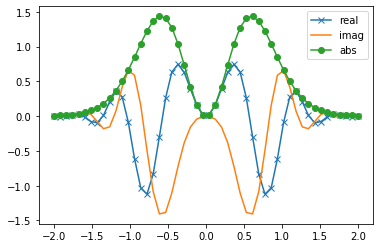

In [8]:
%time
%matplotlib inline
import matplotlib.pyplot as plt

#-----------------------------------
#K_y = np.linspace(-k1, k1, 100)
#INTEGRAND = integrand_cartesian(x_shift, 0.0, 0.0, K_y, 0.0)
#plt.plot(K_y, INTEGRAND.real)
#plt.plot(K_y, INTEGRAND.imag)

Z = np.linspace(-2, 2, 50)
PSI = vec_psi_spherical(-2.0, 0.0, Z)   # at origin
#np.save('PSI.npy', PSI)
#np.load('PSI.npy')

#np.save('PSIz_spherical_m_2_x_-2.npy', PSI)
#PSI = np.load('PSI_cartesian.npy')

#np.save('PSIy_spherical_m_2.npy', PSI)
#PSI = np.load('PSIy_spherical_m_2.npy')

#print(PSI)

plt.plot(Z, PSI.real,    label='real', marker='x')
plt.plot(Z, PSI.imag,    label='imag')
plt.plot(Z, np.abs(PSI), label='abs', marker='o')
plt.legend()
plt.show();